## Air Quality analysis

The aim of the project is simple data analysis of air quality data.  We check statistics of all data and an individual features of our dataset. We also make the outliers detection of individual variables with a few methods such as IQR method and Isolation Forest model.

**Data:**

The data comes from: https://archive.ics.uci.edu/ml/datasets/Air+Quality#

### Import libriaries and data

In [1]:
import os, time, shutil
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

print("*** Packages loaded successfully! ***")

*** Packages loaded successfully! ***


### Optional tutorial configurations

In [2]:
# Save figures?
savefigs = True # True/False

########## Setup local tutorial folders ##########
# create your local tutorial directory in your $HOME
# Default: $HOME/tutorials
tutorials = os.path.join(os.path.expanduser("~"),"tutorials")

# Create local tutorial output folder
# Default: $HOME/tutorials/output/...
tutorial_output = os.path.join(tutorials,"output","aiml_tutorials","aqi")

# Where should we put a local copy of the required tutorial dataset(s) for this tutorial?
# Default: $HOME/tutorials/tutorial_data/...
tutorial_data_dest = os.path.join(os.path.expanduser("~"),"tutorials","tutorial_data","aiml_tutorials/aqi/")

#### Copy over the tutorial data (stored on s3)

In [3]:
"""
Copy the data to your 'local' working tutorial directory
This enables quick access to data files
"""
user_name = os.popen('whoami').read().strip()
print("*** SMCE username: " + user_name + " ***")

if not os.path.exists(tutorials):
    dest_dir_path = Path(tutorials)
    dest_dir_path.mkdir(parents=True, mode=0o777, exist_ok=True) # create the directory for the copied data, if needed
if not os.path.exists(tutorial_data_dest):
    dest_dir_path = Path(tutorial_data_dest)
    dest_dir_path.mkdir(parents=True, mode=0o777, exist_ok=True) # create the directory for the copied data, if needed
    
# Identify the location of the tutorial datasets - this is the source data used in the notebooks
tutorial_data_store_path = '/s3/airborne-smce-prod-user-bucket/tutorial_data/aiml_tutorials/aqi/'

# Using 'shutil' package, copy all the files over
print("*** Tutorial data location ***")
shutil.copytree(tutorial_data_store_path, tutorial_data_dest, dirs_exist_ok=True)
print(tutorial_data_dest)

if not os.path.exists(tutorial_output):
    dest_dir_path = Path(tutorial_output)
    dest_dir_path.mkdir(parents=True, mode=0o777, exist_ok=True) # create the directory for the copied data, if needed
print("*** Tutorial output location ***")
print(tutorial_output)

*** SMCE username: sserbin ***
*** Tutorial data location ***
/home/jovyan/tutorials/tutorial_data/aiml_tutorials/aqi/
*** Tutorial output location ***
/home/jovyan/tutorials/output/aiml_tutorials/aqi


In [4]:
datafile = os.path.join(tutorial_data_dest,'AirQualityUCI.csv')
df = pd.read_csv(datafile, sep=';', decimal=',')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


#### First observations:

In [5]:
df.shape

(9471, 17)

We have 9471 rows divided into 17 columns.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


### Data cleaning

Remove unnecessary variables:

In [7]:
df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

Transform the variable Date:

In [8]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-10-03,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-10-03,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-10-03,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-10-03,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-10-03,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


Checking the missing values in our data:

In [9]:
df.isnull().sum()

Date             5874
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
dtype: int64

We can see that there are gaps in all variables in the same amount. 

### Data analysis

Data visualization:

In [10]:
df_col = df[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', \
             'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', \
             'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]

In [11]:
df_col.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


#### Show the data kernel densities

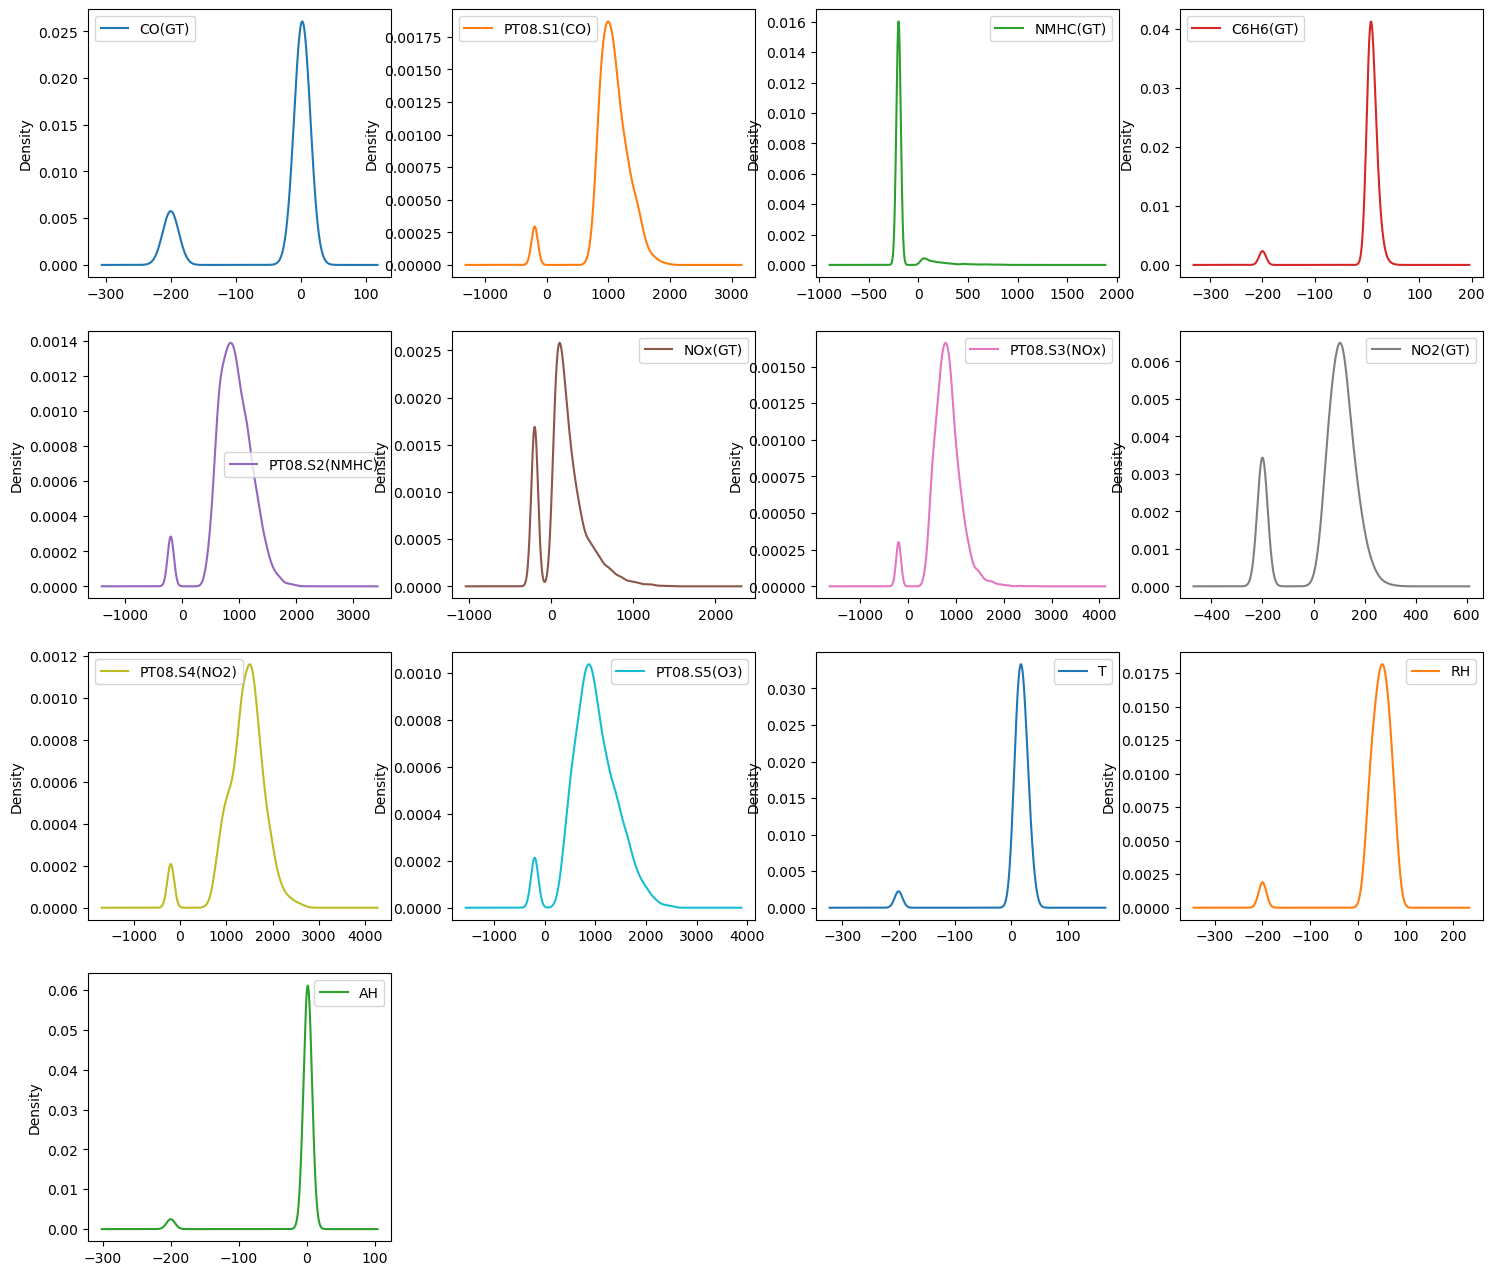

In [15]:
plt.rcParams['figure.figsize'] = [18, 16]
df_col.plot(kind="density", subplots=True, layout=(4,4), sharex=False, sharey=False)

# save figure if requested
if savefigs:
    plt.savefig(os.path.join(tutorial_output,'data_pdfs.pdf'))
    plt.savefig(os.path.join(tutorial_output,'data_pdfs.png'))
    
# show the figure to the screen
plt.show()

Histograms of all variables:

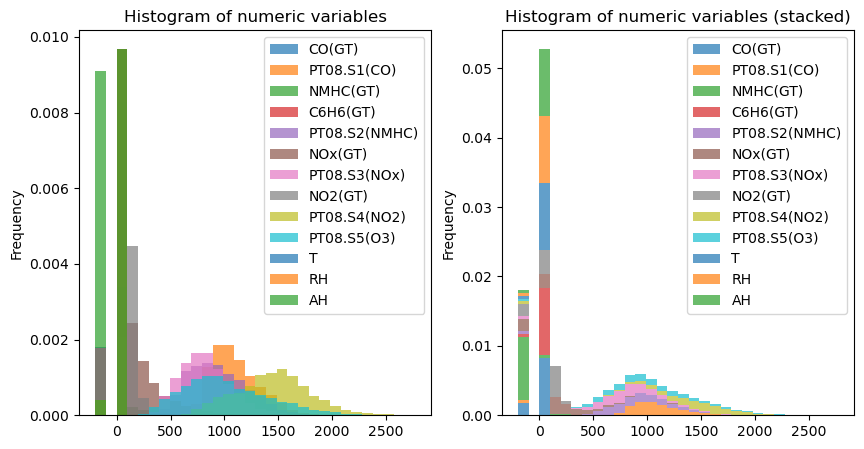

In [17]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
df_col.plot(kind="hist", bins=30, density=True, alpha=0.7, ax=axs[0])
axs[0].set_title('Histogram of numeric variables')
df_col.plot(kind="hist", bins=30, density=True, alpha=0.7, stacked=True, ax=axs[1])
axs[1].set_title('Histogram of numeric variables (stacked)');

# save figure if requested
if savefigs:
    plt.savefig(os.path.join(tutorial_output,'data_histogram.pdf'))
    plt.savefig(os.path.join(tutorial_output,'data_histogram.png'))

The maximum CO concentration:

In [18]:
df.groupby('Date')['CO(GT)'].max().sort_values(ascending=False).head()

Date
2004-02-12    9.4
2004-02-11    9.2
2004-04-11    8.7
2005-10-02    8.4
2004-05-11    8.1
Name: CO(GT), dtype: float64

The maximum CO concentration per year:

In [20]:
df3 = df.set_index('Date').resample("YE")["CO(GT)"].max()
df3.head()

Date
2004-12-31    9.4
2005-12-31    8.4
Name: CO(GT), dtype: float64

The maximum concentration of Nox:

In [21]:
df.groupby('Date')['NOx(GT)'].max().sort_values(ascending=False).head()

Date
2004-11-11    1247.0
2005-11-02    1227.0
2004-02-12    1184.0
2005-05-01    1130.0
2004-04-11    1052.0
Name: NOx(GT), dtype: float64

#### Statistics

In [22]:
df.describe()

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,3597,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2004-09-25 10:18:30.925771648,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
min,2004-01-04 00:00:00,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,2004-05-05 00:00:00,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,2004-09-06 00:00:00,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2005-01-03 00:00:00,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,2005-12-03 00:00:00,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000
std,NaN,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670


Correlation matrix:

In [23]:
corr = df_col.corr()
corr

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.041411,0.128351,-0.031378,0.029926,0.526451,-0.089981,0.671127,-0.073724,0.080310,-0.068939,-0.048227,-0.045892
PT08.S1(CO),0.041411,1.000000,0.170007,0.852687,0.933102,0.277993,0.087019,0.154030,0.845149,0.892434,0.754844,0.745375,0.764903
NMHC(GT),0.128351,0.170007,1.000000,0.037323,0.110104,-0.004427,0.048821,0.103307,0.162680,0.101185,-0.000009,0.008284,0.012500
C6H6(GT),-0.031378,0.852687,0.037323,1.000000,0.767433,-0.001174,0.512193,-0.010992,0.774673,0.641334,0.971375,0.925062,0.984555
PT08.S2(NMHC),0.029926,0.933102,0.110104,0.767433,1.000000,0.331272,-0.073667,0.176488,0.874782,0.909905,0.669025,0.585803,0.646572
NOx(GT),0.526451,0.277993,-0.004427,-0.001174,0.331272,1.000000,-0.436084,0.817139,0.035546,0.461889,-0.138452,-0.053009,-0.095847
PT08.S3(NOx),-0.089981,0.087019,0.048821,0.512193,-0.073667,-0.436084,1.000000,-0.256232,0.122734,-0.208865,0.588111,0.573549,0.621618
NO2(GT),0.671127,0.154030,0.103307,-0.010992,0.176488,0.817139,-0.256232,1.000000,-0.022174,0.253439,-0.084104,-0.081305,-0.060440
PT08.S4(NO2),-0.073724,0.845149,0.162680,0.774673,0.874782,0.035546,0.122734,-0.022174,1.000000,0.723690,0.755060,0.640707,0.691913
PT08.S5(O3),0.080310,0.892434,0.101185,0.641334,0.909905,0.461889,-0.208865,0.253439,0.723690,1.000000,0.503700,0.524955,0.519467


Plot the correlation matrix:

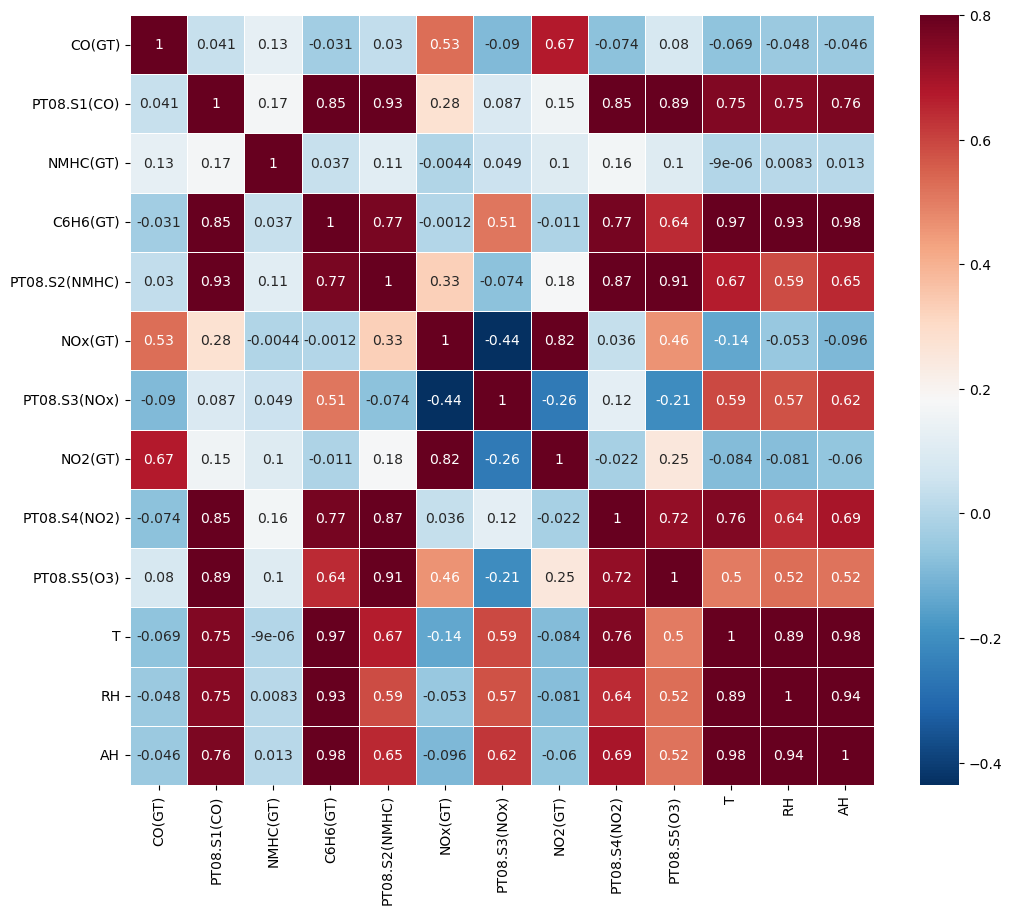

In [24]:
plt.figure(figsize=(12,10))
ax = sns.heatmap(corr, annot=True, linewidth=0.5, cmap='RdBu_r', vmax=.8)
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))

# save figure if requested
if savefigs:
    plt.savefig(os.path.join(tutorial_output,'data_correlation_matrix.pdf'))
    plt.savefig(os.path.join(tutorial_output,'data_correlation_matrix.png'))

plt.show()

### Data analysis of individul variables


We make analysis for two variables: T (temperature) and RH (Relative Humidity (%)). 
Only 4 columns will be needed for further analysis: Date, Time, T and RH:

#### RH variable analysis

We fill missing values of RH variable its median:

In [26]:
df['RH'] = df['RH'].fillna(df['RH'].median())
df['RH'].isnull().sum()

np.int64(0)

The average value of Relative Humidity (RH(%)) in next days:

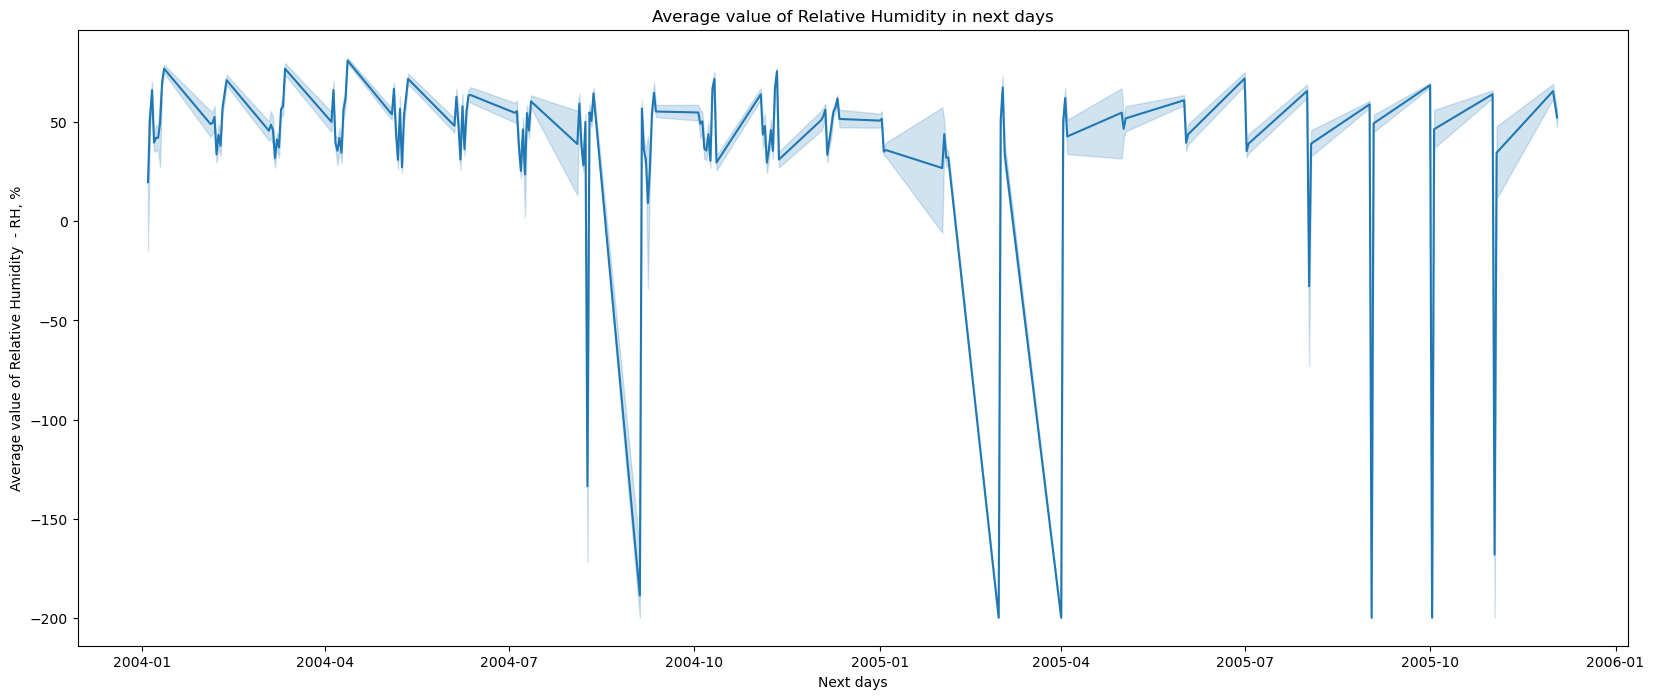

In [29]:
fig = plt.figure(figsize=(20,8))
sns.lineplot(x='Date', y='RH', data=df)
plt.xlabel('Next days')
plt.ylabel('Average value of Relative Humidity  - RH, %')
plt.title('Average value of Relative Humidity in next days');

# save figure if requested
if savefigs:
    plt.savefig(os.path.join(tutorial_output,'RH_timeseries.pdf'))
    plt.savefig(os.path.join(tutorial_output,'RH_timeseries.png'))

plt.show()

**T variable analysis**

Histogram and boxplot of T (temperature):

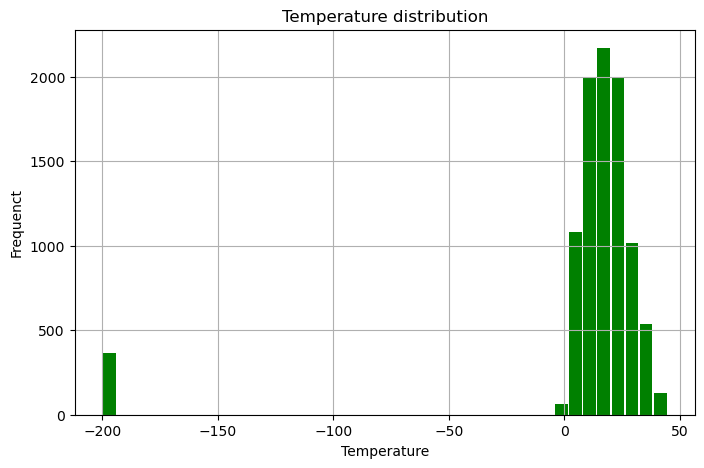

In [30]:
df["T"].hist(bins = 40, figsize=(8,5), rwidth=0.9, color="green")
plt.xlabel("Temperature")
plt.ylabel("Frequenct")
plt.title("Temperature distribution");

# save figure if requested
if savefigs:
    plt.savefig(os.path.join(tutorial_output,'Tair_distribution.pdf'))
    plt.savefig(os.path.join(tutorial_output,'Tair_distribution.png'))

plt.show()

Tair boxplot

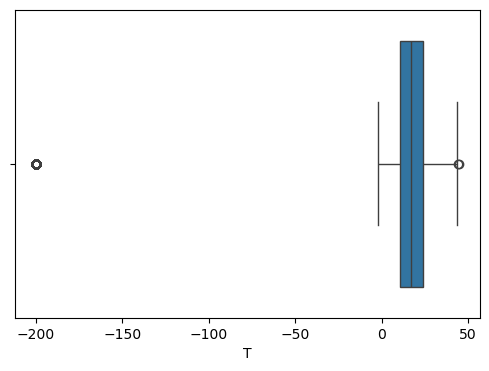

In [32]:
fig = plt.figure(figsize=(6,4))
sns.boxplot(x=df['T']);

# save figure if requested
if savefigs:
    plt.savefig(os.path.join(tutorial_output,'Tair_boxplot.pdf'))
    plt.savefig(os.path.join(tutorial_output,'Tair_boxplot.png'))

plt.show()

The graphs of the 'T' variable show that most of the values in the set are grouped together, and there are also outliers, but with a very low frequency. For the most part, the temperature range is from about 0 to 40 degrees.

**The correlation between variables RH and T.**

In [36]:
df_corr = df[['T', 'RH']]
print("**** Tair and RH dataframe ****")
print(df_corr.head())

print(" ")
print("**** Tair and RH correlation ****")
corr = df_corr.corr()
corr

**** Tair and RH dataframe ****
      T    RH
0  13.6  48.9
1  13.3  47.7
2  11.9  54.0
3  11.0  60.0
4  11.2  59.6
 
**** Tair and RH correlation ****


,T,RH
T,1.000000,0.885911
RH,0.885911,1.000000


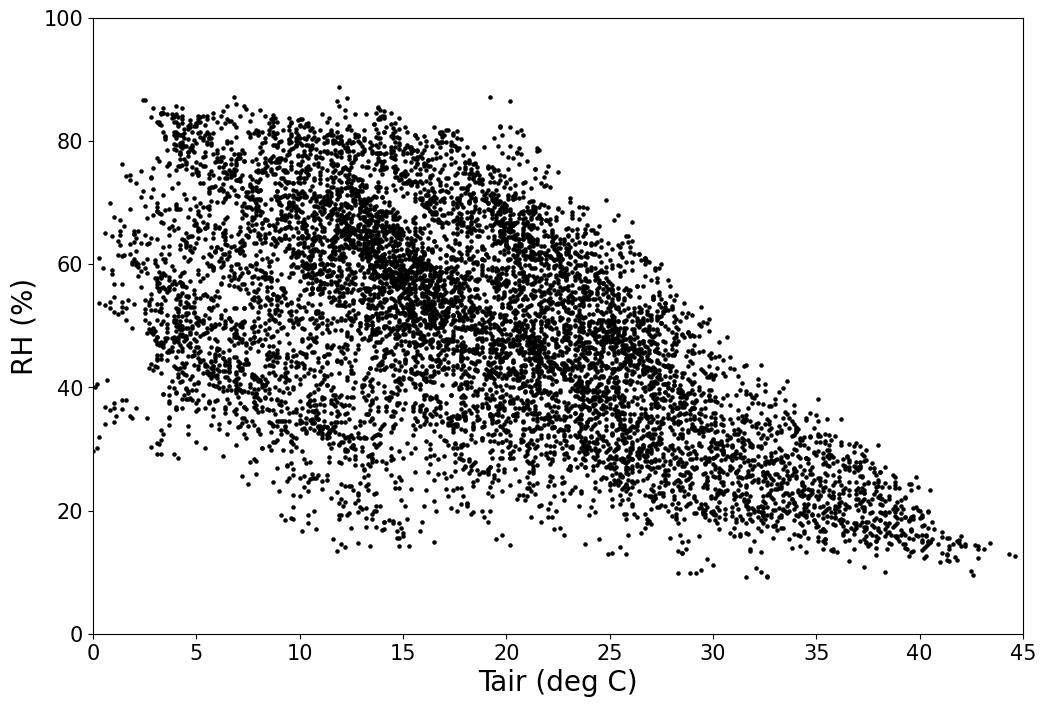

In [50]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(df_corr['T'], df_corr['RH'], c="black", s=5)
ax.set_ylim([0.0, 100])
ax.set_xlim([0.0, 45])
plt.xticks(fontsize=15, rotation=0, horizontalalignment='center')
plt.yticks(fontsize=15, rotation=0)
#ax.plot([0,1],[0,1], transform=ax.transAxes, linestyle='--', color='black')
ax.set_ylabel('RH (%)', size=20)
ax.set_xlabel('Tair (deg C)', size=20)

# save figure if requested
if savefigs:
    plt.savefig(os.path.join(tutorial_output,'Tair_vs_RH_scatterplot.pdf'))
    plt.savefig(os.path.join(tutorial_output,'Tair_vs_RH_scatterplot.png'))

plt.show()

Simple T/RH correlation matrix/heatmap

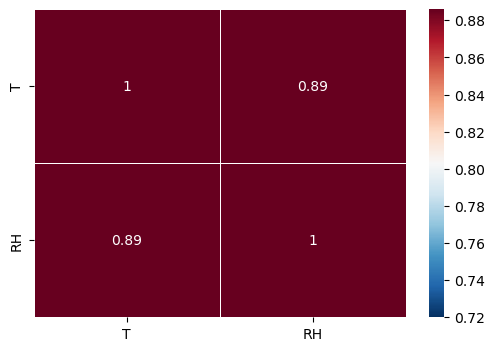

In [39]:
plt.figure(figsize=(6,4))
ax = sns.heatmap(corr, annot=True, linewidth=0.5, cmap='RdBu_r', vmax=.8)
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))

# save figure if requested
if savefigs:
    plt.savefig(os.path.join(tutorial_output,'Tair_RH_heatmap.pdf'))
    plt.savefig(os.path.join(tutorial_output,'Tair_RH_heatmap.png'))
    
plt.show()

Note: From the correlation heatmap we can read that the variables RH and T are strongly correlated with each other and the correlation is positive. The RH variable has a big influence on the T variable, so an increase of temperature influences an increase of RH and vice versa.

### Outlier Identification

In this part we will check if the RH variable has any outliers. 

One method of finding outliers is the box plot. It is a very simple and effective way to visualize outliers. The box plot is based on a summary of five numbers: minimum, first quartile (Q1), median, third quartile (Q3), and maximum. The lower and upper ranges are the boundaries of the data distribution. Any data points that show above or below the ranges can be considered outliers or anomalies. 

Only 4 columns will be needed for further analysis: Date, Time, T and RH

Subset the dataframe to the needed data columns:

In [40]:
df_air = df[['Date', 'Time', 'T', 'RH']]
df_air.head()

,Date,Time,T,RH
0,2004-10-03,18.00.00,13.6,48.9
1,2004-10-03,19.00.00,13.3,47.7
2,2004-10-03,20.00.00,11.9,54.0
3,2004-10-03,21.00.00,11.0,60.0
4,2004-10-03,22.00.00,11.2,59.6


RH outliers

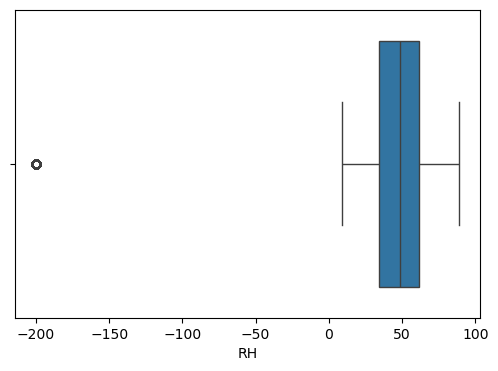

In [51]:
fig = plt.figure(figsize=(6,4))
sns.boxplot(x=df_air ['RH']);

Note: We can see from the chart above that the variable 'RH' has practically no outliers. There is only one point (-200) in the boxplot that can be assigned to the outlier. 


**Identifying Outliers with Interquartile Range(IQR):**

The interquartile range (IQR) is a measure of statistical dispersion and is calculated as the difference between the 75th and 25th percentiles. One can describe it by the formula IQR = Q3 − Q1. We can determine outliers based on IQR results. The 'False' value means that the values are correct, while value is 'True' means the presence of an outlier:

In [54]:
Q1 = df_air ['RH'].quantile(0.25)
Q3 = df_air ['RH'].quantile(0.75)
IQR = Q3 -Q1 
print(round(IQR,2))

27.45


Create outlier filter

In [55]:
outliers_filter = (df_air ['RH'] < (Q1 - 3.0 * IQR)) |(df_air ['RH'] > (Q3 + 3.0 * IQR))
outliers_filter.head(10)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: RH, dtype: bool

In [56]:
outliers_filter.tail()

9466    False
9467    False
9468    False
9469    False
9470    False
Name: RH, dtype: bool

In [57]:
no_outlier_filter = ~(outliers_filter).any(axis=0)
no_outlier_filter

np.False_

The IQR analysis confirmed what was initially read from the box plot.

**Analysis by the Isolation Forest method**

To check whether the assumption read from the box plot is true, we will perform another analysis of outliers using the Isolation Forest method. It also allows you to detect anomalies in the data. 

Isolation Forest detects anomalies solely on the basis that anomalies are few and different data points and is performed without using distance or density measurements. The predict method returns the outliers as 1 for the norm and -1 for the anomaly. 

Now we use data scaling for RH:

In [61]:
rh_data = df_air['RH'].values.reshape(-1, 1)

In [65]:
outliers_fraction = 0.01

In [66]:
model = IsolationForest(contamination=outliers_fraction)
model.fit(rh_data) 
df_air['outlier'] = pd.Series(model.predict(rh_data))

/tmp/ipykernel_1775/3145257964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['outlier'] = pd.Series(model.predict(rh_data))


In [67]:
df_air.head()

,Date,Time,T,RH,outlier
0,2004-10-03,18.00.00,13.6,48.9,1
1,2004-10-03,19.00.00,13.3,47.7,1
2,2004-10-03,20.00.00,11.9,54.0,1
3,2004-10-03,21.00.00,11.0,60.0,1
4,2004-10-03,22.00.00,11.2,59.6,1


The plot of the result:

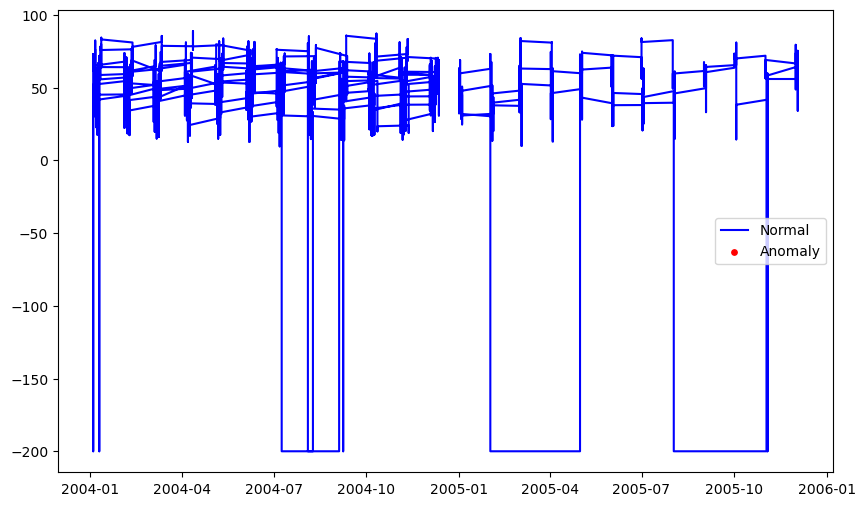

In [69]:
fig, ax = plt.subplots(figsize=(10,6))
a = df_air.loc[df_air['outlier'] == -1, ['Date', 'RH']] 

ax.plot(df_air['Date'], df_air['RH'], color='blue', label = 'Normal')
ax.scatter(a['Date'],a['RH'], color='red', label = 'Anomaly', s=15)
plt.legend()
plt.show();

Change the values into True/False:

In [70]:
df_air['outlier'] = df_air['outlier'].map( {1: False, -1: True} )

/tmp/ipykernel_1775/1529990445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['outlier'] = df_air['outlier'].map( {1: False, -1: True} )


In [71]:
df_air.head()

,Date,Time,T,RH,outlier
0,2004-10-03,18.00.00,13.6,48.9,False
1,2004-10-03,19.00.00,13.3,47.7,False
2,2004-10-03,20.00.00,11.9,54.0,False
3,2004-10-03,21.00.00,11.0,60.0,False
4,2004-10-03,22.00.00,11.2,59.6,False


### Summary

The above analysis confirmed the information previously obtained from the box plot. The number of anomalies in the RH variable is so low that it is practically not detectable by this method. 

### Remove outliers and drop missing/bad data

For further analysis our dataset we can remove some outliers. It  has not a lot of them but the outliers can noise our result, so we can optionally removes all rows of 'RH' variable containing values of -200.

In [72]:
df2 = df[df['RH'] == -200]
df = df.drop(df2.index, axis=0)

In [73]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-10-03,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-10-03,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-10-03,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-10-03,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-10-03,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


Confirm missing/bad data has been removed:

In [77]:
sum(df['RH'] == -200)

0

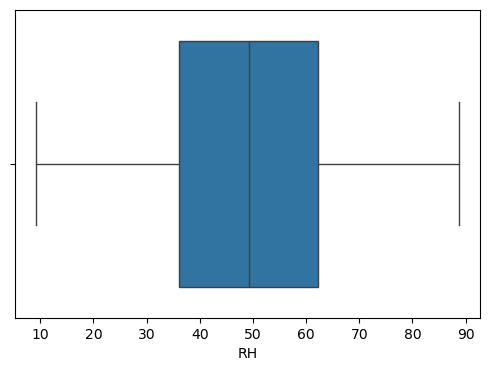

In [79]:
fig = plt.figure(figsize=(6,4))
sns.boxplot(x=df['RH']);

# save figure if requested
if savefigs:
    plt.savefig(os.path.join(tutorial_output,'RH_clean_boxplot.pdf'))
    plt.savefig(os.path.join(tutorial_output,'RH_clean_boxplot.png'))

#### Output the modified dataset

Let's now create a new clean version of the dataset

In [80]:
df.to_csv(os.path.join(tutorial_output,'clean_air.csv'))

Now we can see that he 'RH' variable does not contain any outliers.

In [ ]:
print("**** The End ****")